## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [40]:
import os                                                                       
import re
import time as ti
import numpy as np                                                              
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap
import utils.log_parser as lp

In [5]:
params = {
  "model_type": "conv_lca",
  "model_name": "conv_lca_vh",
  "version": "5.0"}
params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +params["model_name"])

In [6]:
log_file = (params["model_dir"]+"/logfiles/"+params["model_name"]+"_v"+params["version"]+".log")
log_text = lp.load_file(log_file)
model_params = lp.read_params(log_text)
model_schedule = lp.read_schedule(log_text)

In [7]:
log_int = model_params["log_int"]
plot_int = model_params["gen_plot_int"]

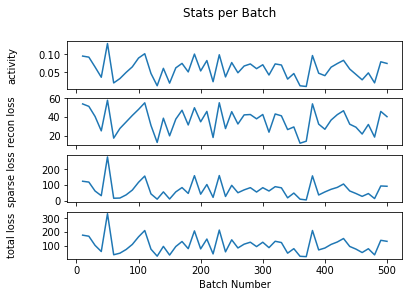

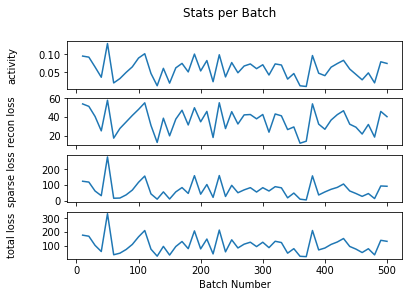

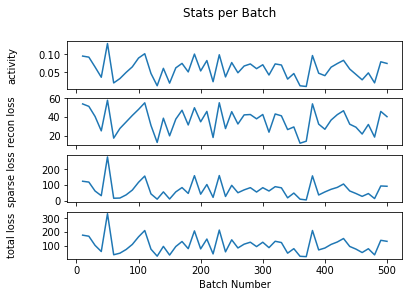

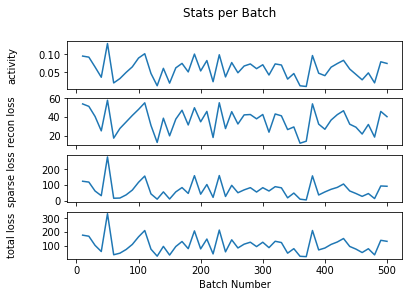

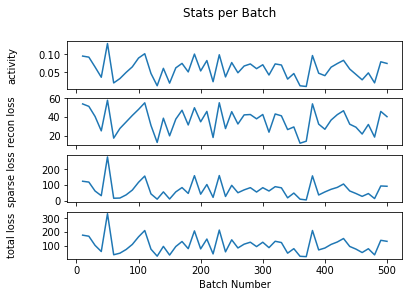

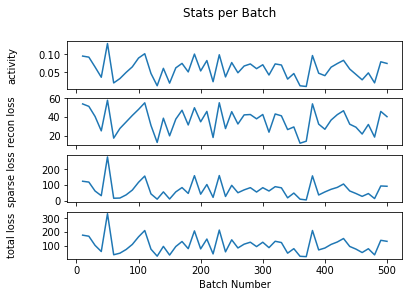

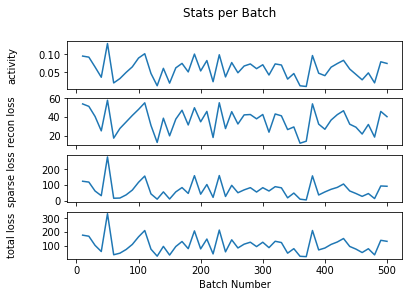

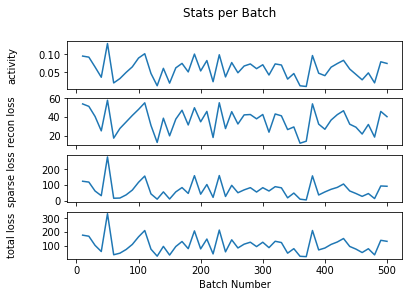

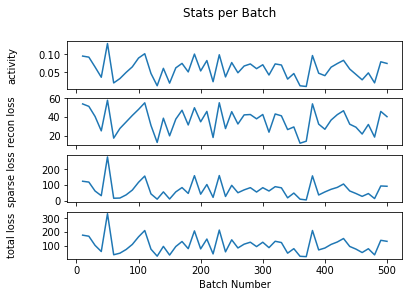

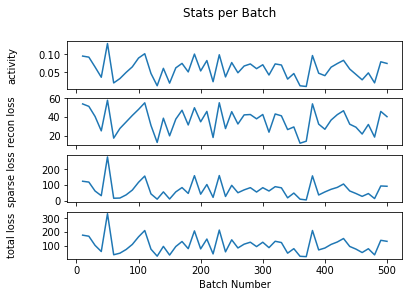

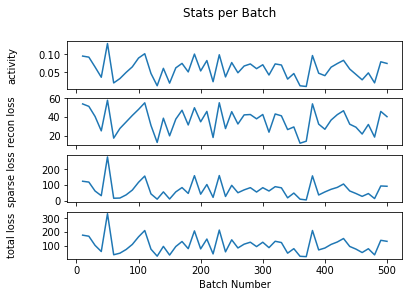

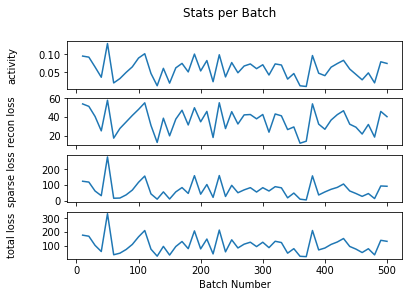

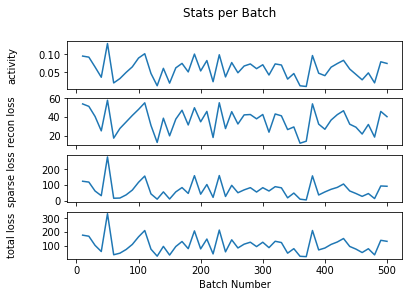

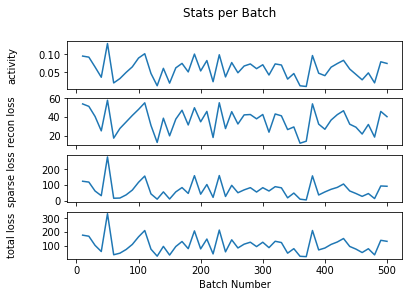

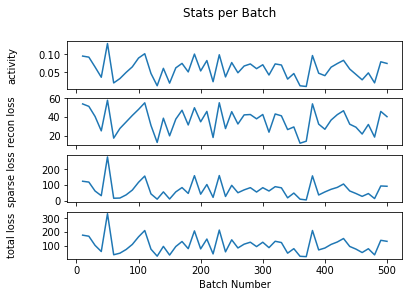

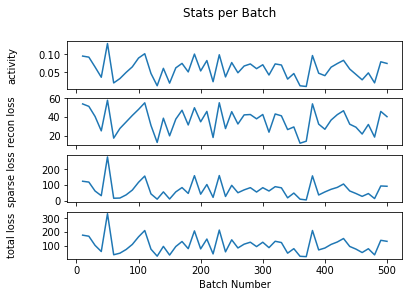

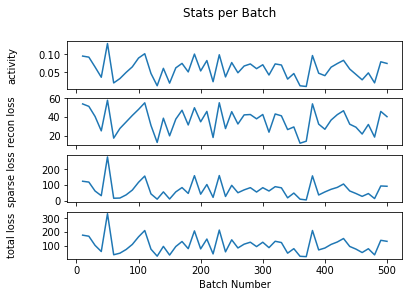

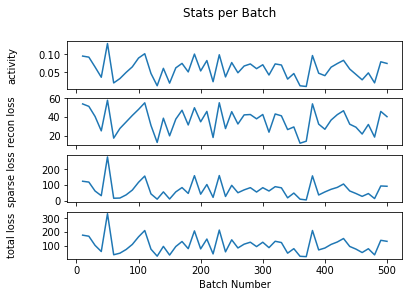

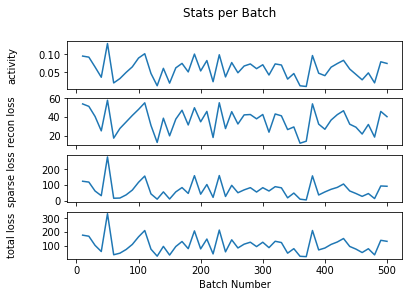

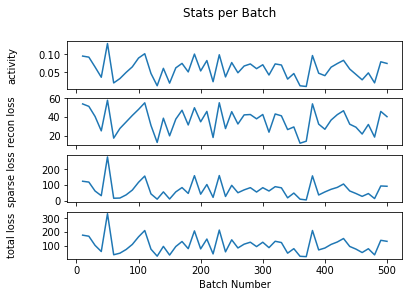

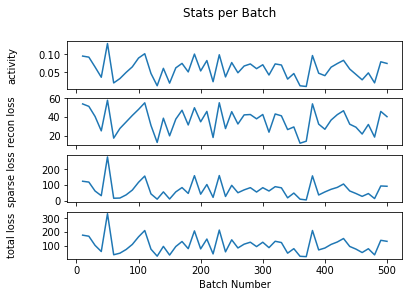

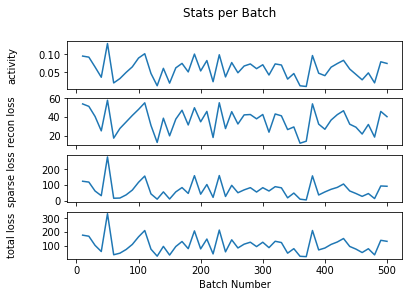

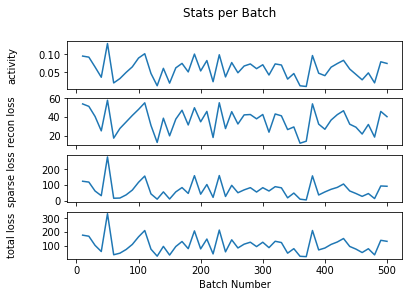

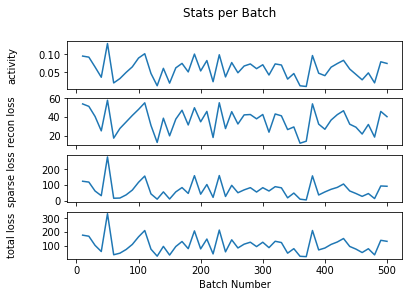

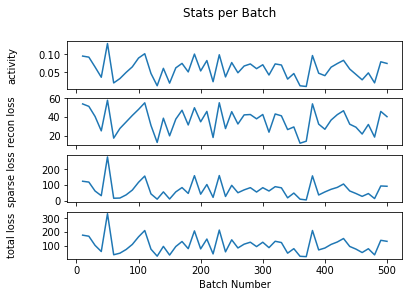

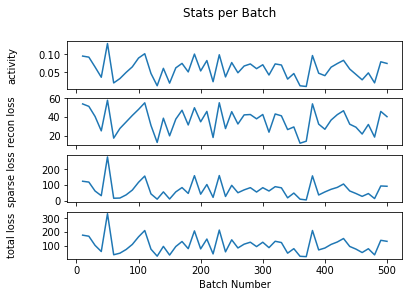

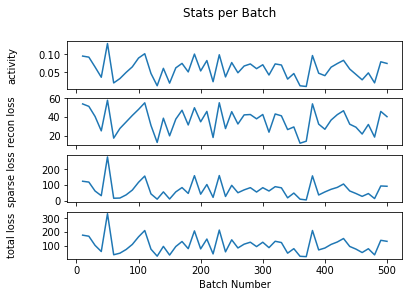

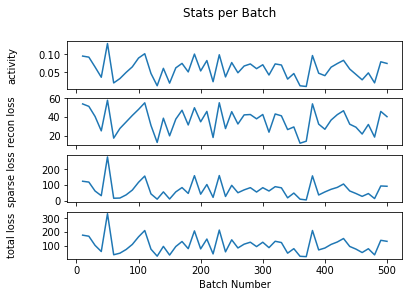

KeyboardInterrupt: 

In [42]:
num_in_avg = 3
time_list = [None,]*(num_in_avg)
for i in range(num_in_avg+1):
  log_mtime = os.stat(log_file).st_mtime
  start = np.floor(ti.clock())
  while np.floor(log_mtime) >= np.floor(os.stat(log_file).st_mtime):
    pass
  end = np.floor(ti.clock())
  if i > 0:
    time_list[i-1] = end - start
avg_time = np.mean(time_list)

log_mtime = os.stat(log_file).st_mtime
first_run = True
while True:
  ti.sleep(avg_time)
  if np.floor(os.stat(log_file).st_mtime) > np.floor(log_mtime):
    if first_run:
      stats_fig = pf.plot_stats(lp.read_stats(log_text),
        keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
        labels=["activity", "recon loss", "sparse loss", "total loss"])
    else:
      stats_fig.canvas.draw() 
      first_run = False
    log_mtime = os.stat(log_file).st_mtime

In [41]:
img_dir = (model_params["out_dir"]+model_params["model_name"]+"/vis/")
file_details = "phi_v"+model_params["version"]+"_"
outputs = [file for file in os.listdir(img_dir) if file_details in file and "dphi" not in file]
indices = sorted([(mid, int(match.group(1)))
  for mid, match in
  enumerate([re.search("_(\d+)",output) for output in outputs])
  if match], key=lambda x:x[1])
disp_filename = img_dir+outputs[indices[-1][0]]
weights = scipy.ndimage.imread(disp_filename)
fig, ax = plt.subplots(1)
ax.imshow(weights)
ax = pf.clear_axis(ax)
plt.show()

OSError: cannot identify image file '/home/dpaiton/Work/Projects/conv_lca_vh/vis/phi_v5.0_10000.pdf'